In [22]:
#start all integration scripts like this

import sys
sys.path.append('/home/pwahle/Organoid-Image-Analysis/scripts/modules')
#alternative to sys.append('...'):
#set PYTHONPATH; in ~/.bashrc add below last line: export PYTHONPATH=/home/<your username>/Organoid-Image-Analysis/scripts/modules
#this option doesn't work for me.

import yaml 
import Paths #all kinds of paths, image paths are functions with default variables plate = "plate6", cycle = 'cycle1'; aligned_images_path has no variable 'cylce'. 

#load parameters
with open("../../params.yml", 'r') as ymlfile: 
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
    
globals().update(cfg) # optional, 'activates' all parameters

In [23]:
from skimage import io
from matplotlib import pyplot as plt
from skimage import filters
import os
import cv2 as cv
import numpy as np
import matplotlib
from skimage.filters import threshold_otsu
from skimage.filters import threshold_multiotsu
import copy
from skimage.feature import blob_log

folder = "/links/groups/treutlein/DATA/imaging/PW/4i/plate6/cycle2/stitched"

img = io.imread(os.path.join(folder, "MAX_Time00000_Point0000_Point00{ii}_ChannelSCF_SD.tif"))


'''folder = "/links/groups/treutlein/DATA/imaging/PW/4i/plate6/AlignedOrganoids/MAX_Time00000_Point0000_Point00{ii}_ChannelSCF_SD/"

img = io.imread(os.path.join(folder, "cycle1_aligned.tif"))'''

dapi = img[2500:3500,2000:3000,2]
membrane = img[2500:3500,2000:3000,1]

#dapi = dapi[200:400,720:920]
#membrane = membrane[200:400,720:920]

In [24]:
import Example

In [25]:
dapi_scale = Example.scale_image(dapi)
membrane_scale = Example.scale_image(membrane)

In [26]:
subtracted = dapi_scale - membrane_scale


threshold = threshold_otsu(subtracted)
subtracted[subtracted < threshold] = 0
subtracted = Example.scale_image(subtracted)

'''from skimage import morphology

selem =  morphology.disk(4)
res = morphology.white_tophat(subtracted, selem)

so_rem = subtracted - res'''

'''fifure = plt.figure(figsize = (20,20))
plt.imshow(subtracted)'''

'fifure = plt.figure(figsize = (20,20))\nplt.imshow(subtracted)'

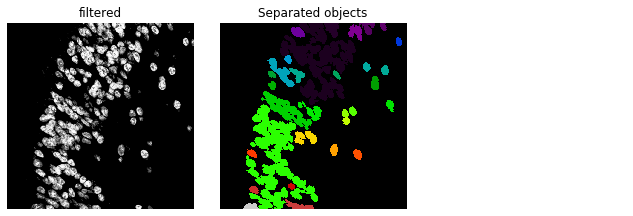

In [27]:
from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max

filtered = filters.gaussian(subtracted, sigma=0.4, preserve_range=True, truncate = 3)
#distance = ndi.distance_transform_edt(subtracted)
local_maxi = peak_local_max(filtered, indices=False, footprint=np.ones((2, 2)),
                            labels=filtered)
markers = ndi.label(local_maxi)[0]
labels = watershed(-filtered, markers, mask=filtered)

#filter labels that have fewer than 1000 elements.
hist = np.ravel(labels)[np.ravel(labels) > 0]
summary_hist = np.histogram(hist, bins = np.append(np.unique(hist),[np.unique(hist).size + 1]))
large_clusters = summary_hist[1][np.nonzero(summary_hist[0] > 1000)]
mask2 = np.isin(labels, large_clusters)
labels[mask2 == False] = 0

#-------------#
fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(filtered, cmap=plt.cm.gray)
ax[0].set_title('filtered')
ax[1].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[1].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

In [ ]:


#for i in np.unique(np.sort(np.ravel(labels))):
'''for i in large_clusters:
    test = copy.copy(labels)
    test[test != i] = 0 
    plt.imshow(test)
    plt.figure(i+1)
    
plt.show()

'''


In [ ]:
test = copy.copy(labels)
test[test != large_clusters[14]] = 0 
plt.imshow(test)


In [8]:
import cv2
import imutils


test = np.where(test > 0.5, 1, 0)
test = test.astype(np.uint8)

cnts = cv2.findContours(test, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

In [17]:
# determine the most extreme points along the contour
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

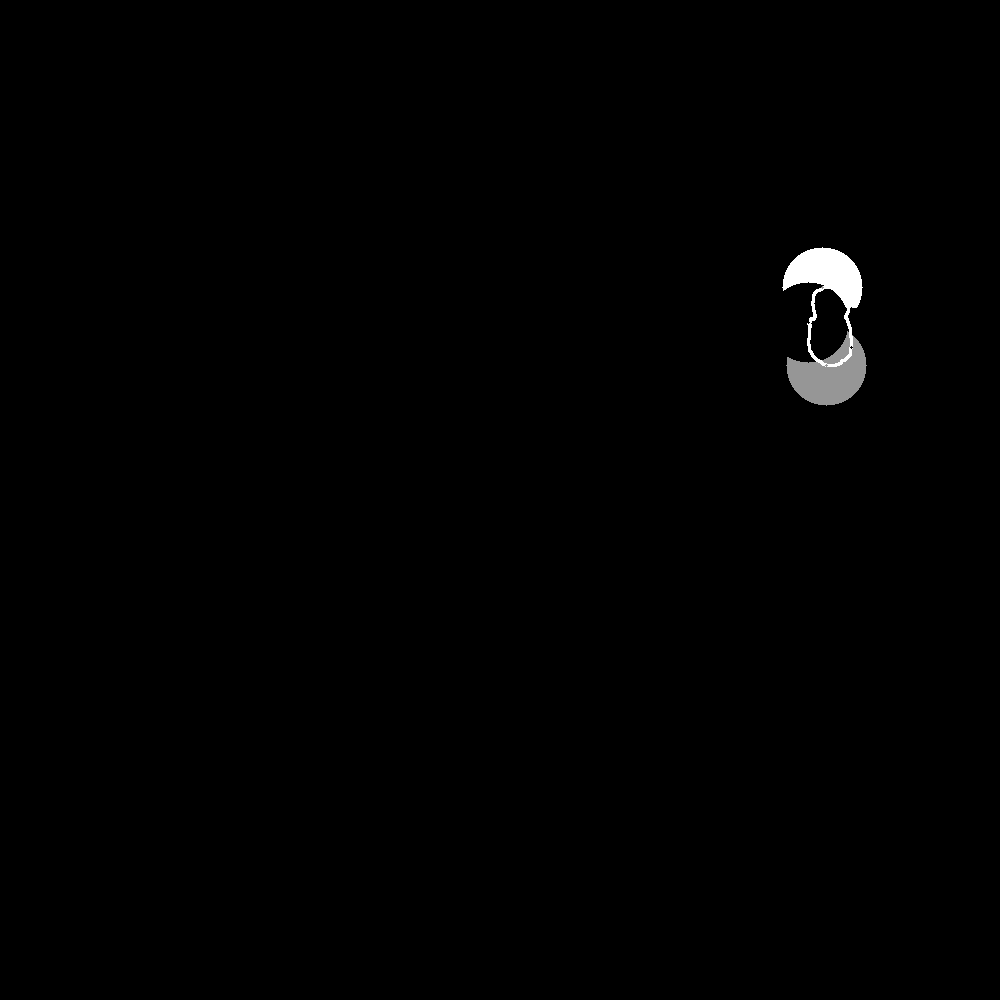

In [39]:
image = test

#cv2.circle(image, center_coordinates, radius, color, thickness)
#cv2.drawContours(image, contours, contourIdx, color[, thickness[, lineType[, hierarchy[, maxLevel[, offset]]]]])


cv2.drawContours(image, [c], -1, (255, 255, 255), 2)
cv2.circle(image, extLeft, 1, (0, 0, 150), -1)
cv2.circle(image, extRight, 1, (0, 150, 0), -1)
cv2.circle(image, extTop, 1, (150, 0, 0), -1)
cv2.circle(image, extBot, 1, (150, 150, 0), -1)
# show the output image

from google.colab.patches import cv2_imshow
cv2_imshow(image)




In [41]:
from matplotlib import pyplot as plt

from skimage import data
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.transform import warp, AffineTransform
from skimage.draw import ellipse

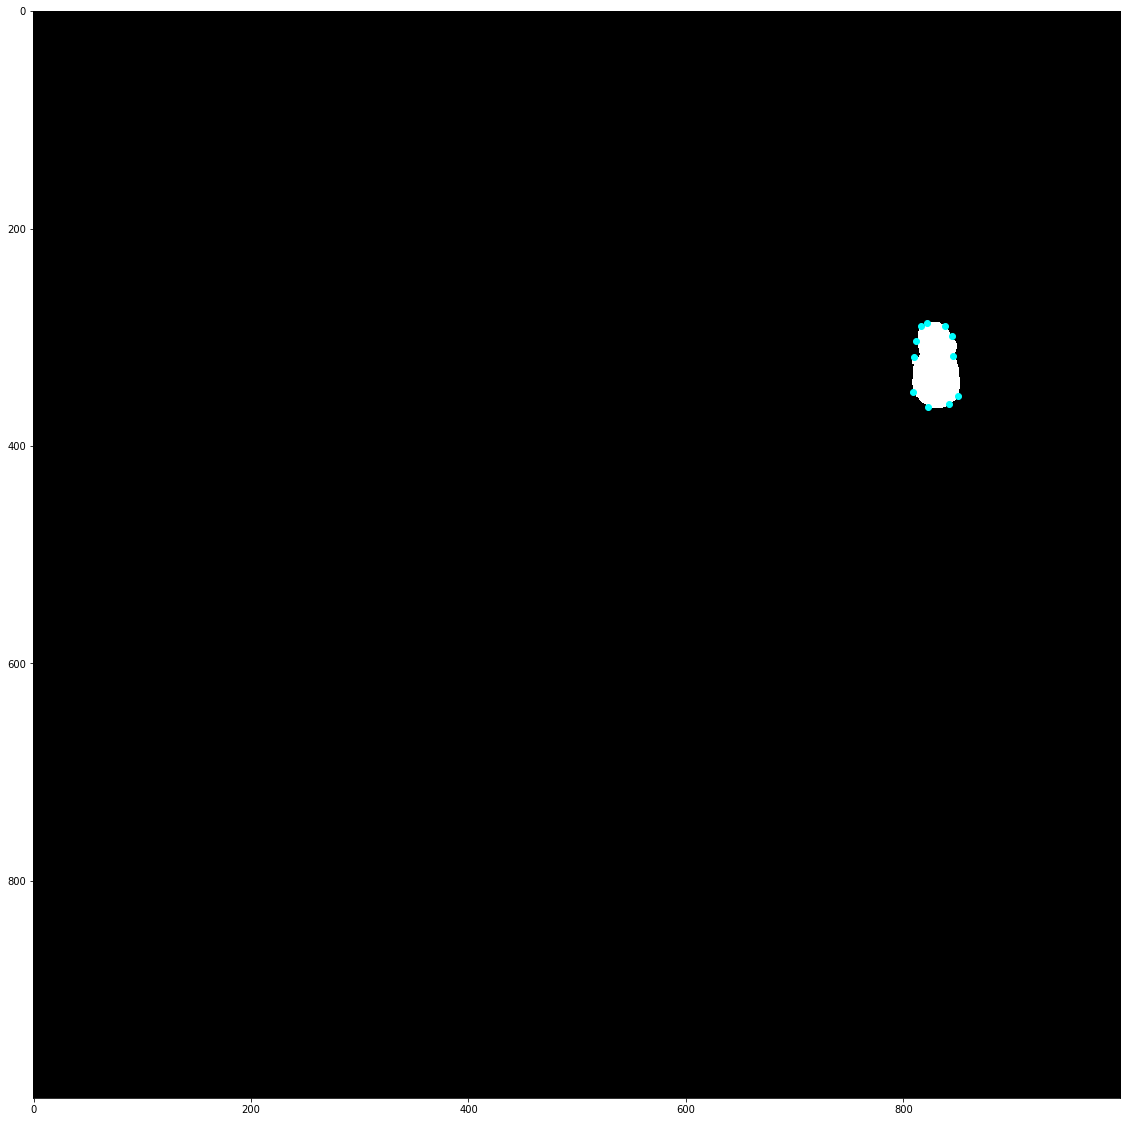

In [54]:
coords = corner_peaks(corner_harris(test), min_distance=5)
coords_subpix = corner_subpix(test, coords, window_size=13)

fig, ax = plt.subplots(figsize = (20,20))
ax.imshow(test, cmap=plt.cm.gray)
ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
#ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
plt.show()

In [64]:
from skimage.measure import label, regionprops, regionprops_table
import math

regions = regionprops(test)

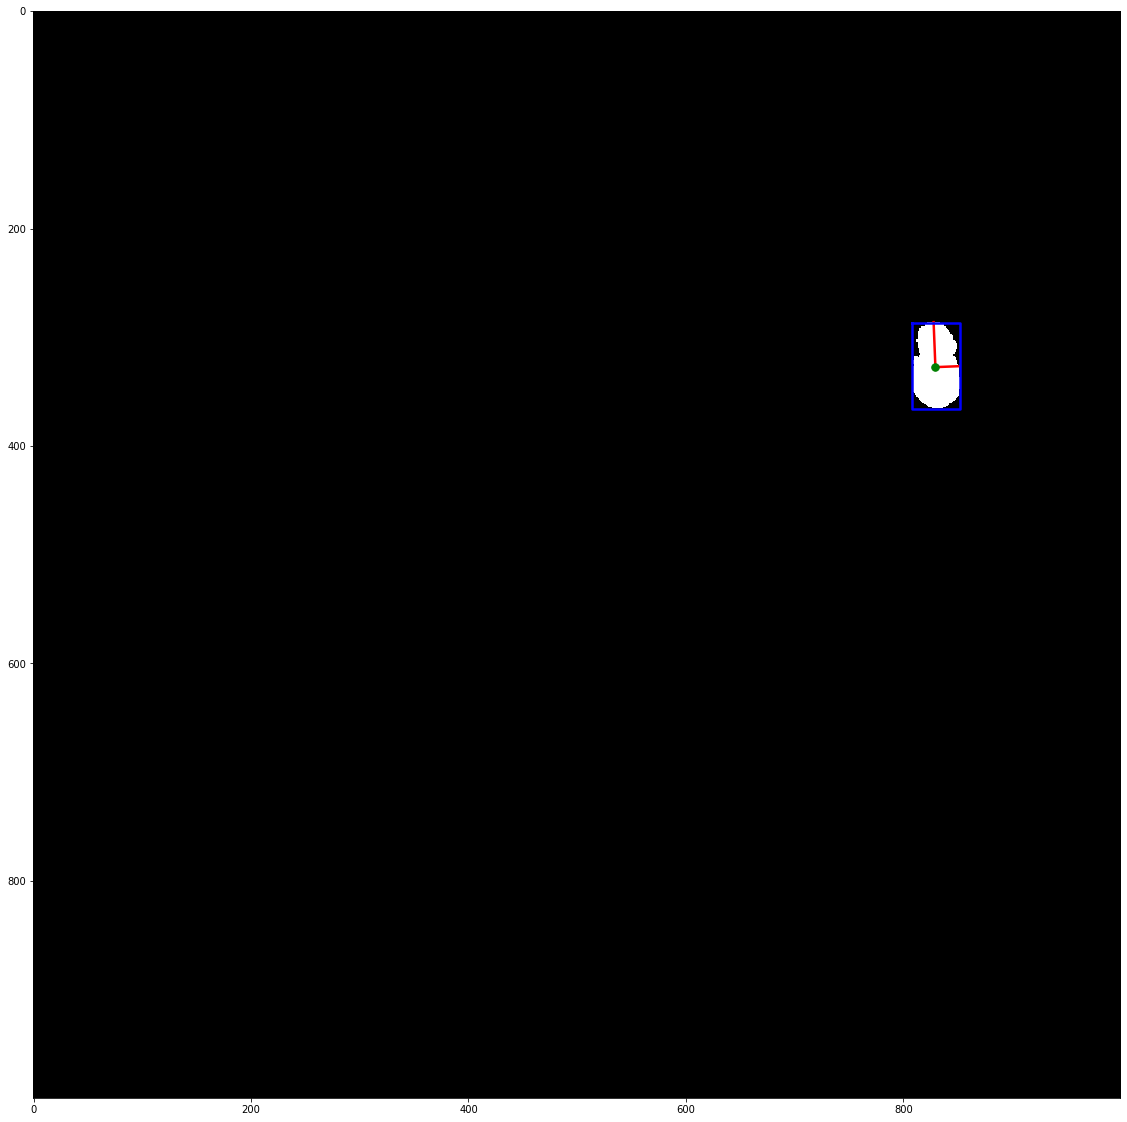

In [67]:
fig, ax = plt.subplots(figsize = (20,20))
ax.imshow(test, cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)

plt.show()

In [111]:
cnts = cv2.findContours(test, 1,2)
area = cv2.contourArea(cnts[0])
hull = cv2.convexHull(cnts[0],returnPoints = False)
defects = cv2.convexityDefects(cnt,hull)

error: OpenCV(4.2.0) /io/opencv/modules/imgproc/src/convhull.cpp:137: error: (-215:Assertion failed) total >= 0 && (depth == CV_32F || depth == CV_32S) in function 'convexHull'
